In [1]:
from transformers import AutoConfig, AlbertTokenizerFast, AutoModelForSequenceClassification, DistilBertTokenizerFast
from transformers import BertTokenizerFast
from transformers import TrainingArguments, Trainer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Dropout
from sklearn.metrics import accuracy_score

In [2]:
reviews_df = pd.read_csv('amazon_reviews.csv', index_col=0)
reviews_df.head(5)

,rating,text
0,5,\n I tested the AA size Amazon brand battery ...
1,1,\n I've been buying AA and AAA batteries from...
2,1,\n Don't buy these. I did save a bunch of $'...
3,1,\n I loved these batteries when I first star...
4,1,\n I read a lot of reviews and convinced myse...


<AxesSubplot:xlabel='rating', ylabel='count'>

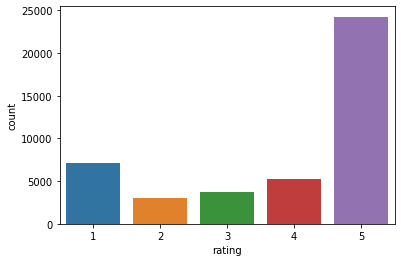

In [3]:
sns.countplot(x='rating', data=reviews_df)

In [4]:
rows_to_drop = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 17000, False)
#rows_to_drop1 = np.random.choice(reviews_df[reviews_df['rating'] == 5].index, 20000, False)
#rows_to_drop2 = np.random.choice(reviews_df[reviews_df['rating'] == 1].index, 3000, False)
#rows_to_drop3 = np.random.choice(reviews_df[reviews_df['rating'] == 4].index, 1500, False)

#rows_to_drop = np.concatenate([rows_to_drop1, rows_to_drop2, rows_to_drop3])
reviews_df.drop(rows_to_drop, axis=0, inplace=True)

<AxesSubplot:xlabel='rating', ylabel='count'>

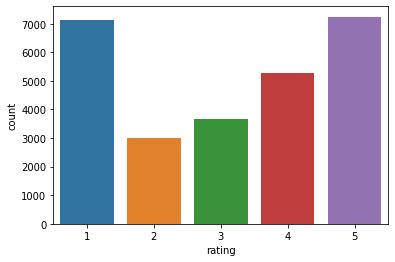

In [5]:
sns.countplot(x='rating', data=reviews_df)

In [ ]:
import gc
del t
gc.collect()
torch.cuda.empty_cache()

In [6]:
#bert-base-uncased
model_name = 'bert-base-uncased'

config = AutoConfig.from_pretrained(model_name)
config.output_hidden_states = False
config.hidden_dropout_prob = 0.15
config.num_labels = 5
config.output_attentions = False

tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

t = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).cuda()


#for parameter in t.albert.parameters():
#    parameter.requires_grad = False
    
print(t)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.15, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [7]:
X_train, X_test, y_train, y_test = train_test_split(reviews_df['text'], reviews_df['rating'], test_size=.2)

In [8]:
class ReviewsDataset(torch.utils.data.Dataset):
    
    def __init__(self, texts, ratings):
        
        tokens = tokenizer(
            text=texts.tolist(), 
            return_tensors='pt',
            padding=True,
            truncation=True,
            add_special_tokens=True,
            return_attention_mask=True
        )
        
        self.text = tokens['input_ids']
        self.attention_mask = tokens['attention_mask']
        self.ratings = ratings.reset_index().drop('index', axis=1)
        self.ratings = self.ratings-1
        
    def __getitem__(self, idx):
        item = {'input_ids': self.text[idx], 'attention_mask':self.attention_mask[idx], 'labels': self.ratings.iloc[idx] }
        return item
    
    def __len__(self):
        return self.ratings.size

In [9]:
train_ds = ReviewsDataset(X_train, y_train)
test_ds = ReviewsDataset(X_test, y_test)

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    softmax = torch.nn.Softmax(dim=1)(torch.Tensor(logits))
    predictions = torch.max(softmax, dim=1)
    
    return {'accuracy': accuracy_score(y_true=labels.reshape(-1), y_pred=predictions[1])}

training_args = TrainingArguments(
    "transformer_checkpoints", 
    overwrite_output_dir=True,
    evaluation_strategy="epoch", 
    logging_strategy='epoch',
    dataloader_pin_memory=True, 
    per_device_train_batch_size=8,
    num_train_epochs=4.0,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    metric_for_best_model='eval_accuracy',
    learning_rate=3e-5,
    lr_scheduler_type='cosine',
    warmup_steps=300
)

trainer = Trainer(
    model=t, 
    args=training_args, 
    train_dataset=train_ds, 
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,1.007700,0.825294,0.676800,133.978400,39.282000
2,0.671800,0.766249,0.724302,133.965000,39.286000
3,0.427800,0.930511,0.733612,134.046000,39.263000
4,0.284300,1.155779,0.738552,133.830300,39.326000


TrainOutput(global_step=10528, training_loss=0.5979328271465824, metrics={'train_runtime': 7066.9341, 'train_samples_per_second': 1.49, 'total_flos': 2.8319933512704e+16, 'epoch': 4.0})

In [13]:
trainer.evaluate(train_ds)

{'eval_loss': 0.20840643346309662,
 'eval_accuracy': 0.9422802850356294,
 'eval_runtime': 531.7871,
 'eval_samples_per_second': 39.584,
 'epoch': 4.0}

In [12]:
trainer.save_model('albert_base_uncased_model')